# Tutorial 2: Photometric reverberation mapping

*by Isidora Jankov, isidora_jankov@matf.bg.ac.rs*

### Table of contents
- What is (photometric) reverberation mapping?
- Downloading multiband light curves using ZTF API
- Generating artificial AGN light curves
- PhotoRM: simulated light curves
- PhotoRM: ZTF light curves
- Python resources
- References

### Installation & Dependencies

- Tested with Python 3.7

**Python modules:**

- pandas (tested with version 1.3)
- numpy (tested with version 1.21)
- matplotlib (tested with version 3.4)
- scipy (tested with version 1.5)
- astropy (tested with version 4.3)
- speclite (tested with version 0.13)

**Compiled Fortran programs (download source code [here](https://www.weizmann.ac.il/particle/tal/research-activities/software)):**
- ZDCF
- PLIKE  

Place them in the directory you specified in `path` variable in this notebook (I placed my executable programs in a subfolder of the direcotory where this notebook is found called fortran_dir, so my `path` = './fortran_dir')

**Other packages:**
- `wget` (download on Ubuntu: `sudo apt install wget`)

Linux distributions and MacOS usually have this already installed.

**Additional files:**
- photRM.py
- add_asym.py
- ZTF filters files (ztf-g.ecsv, ztf-r.ecsv, ztf-i.ecsv). I placed them in ./ZTF_data/ZTF_filters.
- composite quaras spectrum file (comp_spec.txt)

# Acknowledgments

- Notebook uses `photRM` module containing two functions for generating artificial AGN light curves and one function for plotting filter response curves originally written by **dr Anđelka Kovačević**. 
- **Isidora Jankov** added more functionality to that code, improved its efficiency by introducing numpy arrays instead of nested for loops, written proper documentation and included them in the `photRM` module.
- The notebook also uses two programs (ZDCF and PLIKE) originally written in Fortran by **dr Tal Alexander**.
- Function `get_ZTF_DR_lc()` for downloading ZTF light curves was kindly provided by **dr Paula Sánchez Sáez**.

# Summary

After introducing the user to basic theoretical framework, we will perform a complete photometric reverberation mapping exercise, from data acquisition and generation to time-lag estimation.

# What is (photometric) reverberation mapping?

Reverberation mapping is a *direct* method for estimating the dimensions of the broad-line region (BLR) in active galactic nuclei (AGN), and hence for the black hole mass estimation. By applying virial theorem, black hole mass can be calculated in the following way:

$$
\begin{align}
M_{BH} = f \frac{R_{BLR}V^2}{G}
\end{align}
$$

where $R_{BLR}$ is the BLR radius, $V$ is BLR gas cloud velocity, $f$ is dimensionless factor depending on geometry and kinematics of the BLR and $G$ is gravitational constant.

This method is based on the fact that light originating from the AGN central engine travels to gas clouds located at some distance from that engine (but still under the strong influence of the supermassive black hole) and photoionizes the atoms there. These gas clouds, collectively called the broad-line region (BLR), now emit photons as a *response* to the continuum variations.

This delayed response is proportional to the size of the BLR and can be quantified by analizing AGN light curves in the spectral ranges typical for the continuum  and  BLR emission. The most accurate method is to analize spectral light curves (like ones below), but photometric light curves are also suitable for this kind of analysis under right circumstances. Although less accurate, they are more easily obtained and are planned in the large sky surveys, such as Legacy Survey of Space and Time (LSST) conducted by Vera C. Rubin Observatory in Chile.

<table><tr>
<td> <img src="figs/flare.png" alt="Drawing" style="width: 300px; hight=150px"/> </td>
<td> <img src="figs/reverberation.png" alt="Drawing" style="width: 50px; hight=100px"/> </td>
</tr></table>

### Quick run through the Photo-RM formalism

For example, if we consider a low redshift ($z = 0.005$) AGN, the continuum emission is covered by the $i$-band, and H$\alpha$ and H$\beta$ line emission superimposed on the continuum is covered by the $r$ and $g$ bands, respectively. Here is a nice little graph to illustrate this:

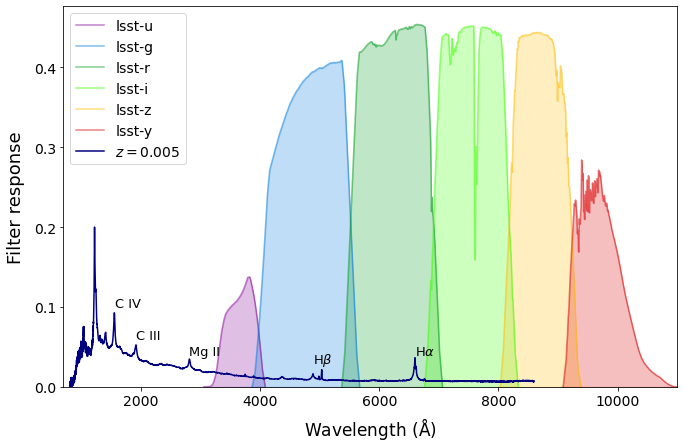

In [3]:
import photRM
photRM.filters_viz(z=0.005, phot_sys='LSST', save=False)

Contrary to the spectroscopic light curves, photometric light curves contain both continuum and line emission, so classical cross-correlation is not applicable to those light curves. That is why we use the formalism explained in Chelouche & Daniel (2012).

**Steps:**

- identify suitable filters: one needs to cover continuum emission ($X$-band) and the other needs to cover continuum + line emission ($Y$-band).
- calculate auto-correlation function (ACF) of the continuum light curve ($X$-band)
- calculate cross-correlation function (CCF) between the continuum light curve  ($X$-band) and continuum+line light curve ($Y$-band)
- take their difference:
 </div>

$$
\begin{align}
CCF(\tau) = CCF_{YX}(\tau) - ACF_{X}(\tau)
\end{align}
$$

- find the peak in their difference, it will correspond to the time-lag ($\tau$)

<a class="anchor" id="import"></a>
# Imports and setup

In [15]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

# Custom libraries
import photRM

%matplotlib inline

# Downloading multiband light curves using ZTF API

In this section, we show how to download ZTF Data Release light curves, using the ZTF API. 
For more details about ZTF service, go to their documentation: https://irsa.ipac.caltech.edu/data/ZTF/docs/releases/dr08/ztf_release_notes_dr08.pdf
See section "iii. Querying Lightcurves using the API"

More details can be found here: https://irsa.ipac.caltech.edu/docs/program_interface/ztf_lightcurve_api.html

In [6]:
# Prerequisites: wget installed

def get_ZTF_DR_lc(name, ra, dec, band, dr_path, keep_all_columns = False):
    
    """
    Author: Paula Sánchez Sáez, PhD
    
    Function to dowload an individual ZTF light curve using the ZTF API. 
    For more details about ZTF service, go to their documentation:
    https://irsa.ipac.caltech.edu/data/ZTF/docs/releases/dr08/ztf_release_notes_dr08.pdf 
    See section "iii. Querying Lightcurves using the API."
    
    Parameters:
    -----------
    name: str
        Object name (e.g. the object "SDSS J005132.94+180120.5" should be refered here only by "J005132.94+180120.5")
    ra: float
        Right ascension of the object (in degrees).
    dec: float
        Declination of the object (in degrees).
    band: {'g', 'r', 'i'}
        ZTF photometric band.
    dr_path: str
        Path to the download directory.
    keep_all_columns: bool, default=False
        If False, only the most important light curve parameters will be retrieved. Otherwise, keep all the columns.
        
    Returns:
    --------
    df: pd.DataFrame
        DataFrame containing the measurments of the retrieved light curve.
    """
    
    if os.path.exists(dr_path+name+'_DR_'+band+'band.csv'): # this checks whether the light curve is already available in your local folder
        df = pd.read_csv(dr_path+name+'_DR_'+band+'band.csv')
    else:
        cmd ='wget -O '+dr_path+name+'_DR_'+band+'band.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE '+str(ra)+' '+str(dec)+' 0.000277778&BANDNAME='+band+'&FORMAT=csv"'
        os.system(cmd)
        df = pd.read_csv(dr_path+name+'_DR_'+band+'band.csv')
    
    if keep_all_columns: print("DR lc for object %s in band %s saved" % (name,band))
    
    else:
        
        # here we select the most important columns.     
        df = df[['oid','mjd','mag','magerr','catflags','filtercode','ra','dec']]

        df.to_csv(dr_path+name+'_DR_'+band+'band.csv', index=False)
        print("DR lc for object %s in band %s saved" % (name,band))

    return(df)

Let's use this function to download light curves in all three bands ($g$, $r$ and $i$) using RA and DEC from a user provided object catalogue.

In [7]:
sources = pd.read_csv('ZTF_data/obj_catalog.csv')
display(sources.head())

,name,ra,dec,z,type
0,SDSS J081109.38+172928.9,122.789120,17.491364,0.39,Q
1,SDSS J162206.75+434636.7,245.528148,43.776861,0.66,Q
2,SDSS J124157.25+595528.1,190.488562,59.924505,0.63,Q
3,SDSS J235939.10+212908.3,359.912939,21.485675,1.71,Q
4,SDSS J092030.98-013253.2,140.129104,-1.548115,2.24,Q


*This is a subset of combined catalogue of known AGNs described in [Sánchez-Sáez, P. et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021AJ....162..206S/abstract)*

As you can see, this catalogue has a column 'name' but the name of the object is not in the correct format to use in the `get_ZTF_DR_lc()` function. We need to clean the data:

In [8]:
# Select only relevant part of the object name (exclude 'SDSS ')
new_names = sources['name'].str.replace("SDSS ", "")
sources.loc[:,'name'] = new_names
display(sources.head())

,name,ra,dec,z,type
0,J081109.38+172928.9,122.789120,17.491364,0.39,Q
1,J162206.75+434636.7,245.528148,43.776861,0.66,Q
2,J124157.25+595528.1,190.488562,59.924505,0.63,Q
3,J235939.10+212908.3,359.912939,21.485675,1.71,Q
4,J092030.98-013253.2,140.129104,-1.548115,2.24,Q


In [9]:
dr_path = './ZTF_data/ZTF_DR_data/' # where to save the DR light curve data in csv format


# Download g, r and i band light curves for first 5 objects in the catalogue 

name = sources.name[:5] # sources['nahttp://localhost:8888/notebooks/Jupyter%20Notebooks/LSST/PhotoRM%20-%20AstroDataLab%20integration/%5BTUTORIAL_SHORT%5D%20PhotoRM%20NB.ipynb#me'] = sources.name
ra = sources.ra[:5]
dec = sources.dec[:5]

for i in range(len(ra.values)): # use the proper names for the name, RA, and dec columns from your catalog
    try:
    #print(type(name.values[i]), type(ra.values[i]), type(dec.values[i]))
        lcg= get_ZTF_DR_lc(name.iloc[i],ra.values[i], dec.values[i], 'g', dr_path)
    except:   
        print("unsuccessful processing of %s in g band" % (name.iloc[i])) #the light curve is probably not available in the ZTF DRs
    try:
        lcr= get_ZTF_DR_lc(name.iloc[i],ra.values[i], dec.values[i], 'r', dr_path)
    except:
        print("unsuccessful processing of %s in r band" % (name.iloc[i])) #the light curve is probably not available in the ZTF DRs
    try:
        lci= get_ZTF_DR_lc(name.iloc[i],ra.values[i], dec.values[i], 'i', dr_path)
    except:
        print("unsuccessful processing of %s in i band" % (name.iloc[i])) #the light curve is probably not available in the ZTF DRs
    print(62*'-')
    

DR lc for object J081109.38+172928.9 in band g saved
DR lc for object J081109.38+172928.9 in band r saved
DR lc for object J081109.38+172928.9 in band i saved
--------------------------------------------------------------
DR lc for object J162206.75+434636.7 in band g saved
DR lc for object J162206.75+434636.7 in band r saved
DR lc for object J162206.75+434636.7 in band i saved
--------------------------------------------------------------
DR lc for object J124157.25+595528.1 in band g saved
DR lc for object J124157.25+595528.1 in band r saved
DR lc for object J124157.25+595528.1 in band i saved
--------------------------------------------------------------
DR lc for object J235939.10+212908.3 in band g saved
DR lc for object J235939.10+212908.3 in band r saved
DR lc for object J235939.10+212908.3 in band i saved
--------------------------------------------------------------
DR lc for object J092030.98-013253.2 in band g saved
DR lc for object J092030.98-013253.2 in band r saved
DR lc 

In [10]:
# Read the downloaded light curves for one object

obj_name = name.iloc[1]
print("Object name: SDSS {}".format(obj_name))

lc_g = pd.read_csv(dr_path+obj_name+'_DR_'+'g'+'band.csv')
lc_r = pd.read_csv(dr_path+obj_name+'_DR_'+'r'+'band.csv')
lc_i = pd.read_csv(dr_path+obj_name+'_DR_'+'i'+'band.csv')

# Show an example of the light curve table in one band
print("Band: r")
display(lc_r.tail())

Object name: SDSS J162206.75+434636.7
Band: r


,oid,mjd,mag,magerr,catflags,filtercode,ra,dec
984,1761207200022593,59052.173380,20.029457,0.112211,0,zr,245.528090,43.776806
985,1761207200022593,59059.165393,20.060129,0.114621,0,zr,245.528170,43.776844
986,1761207200022593,59061.355683,19.785492,0.094292,0,zr,245.528227,43.776910
987,1761207200022593,59087.139861,20.001333,0.110031,0,zr,245.528063,43.776880
988,1761207200022593,59087.140799,19.975819,0.108078,0,zr,245.528199,43.776874


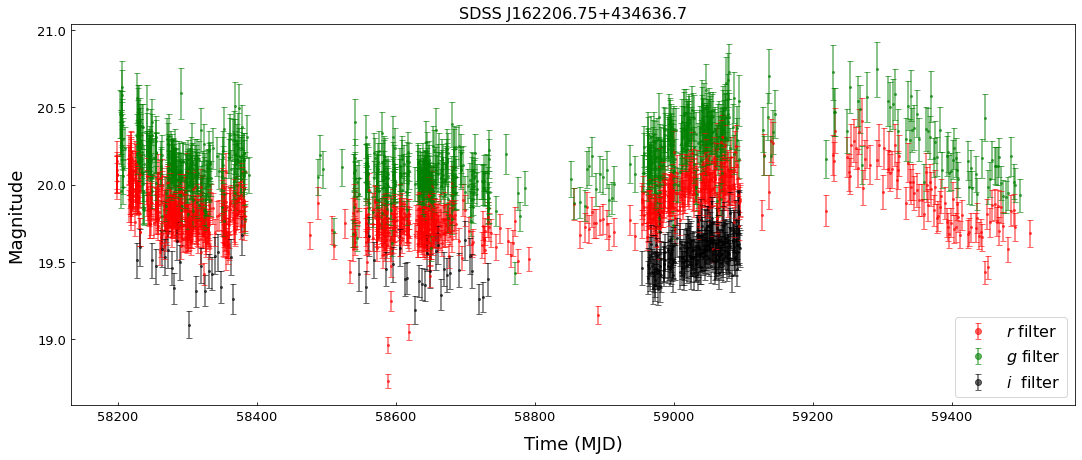

In [11]:
# Plot the light curves       

fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot()

ax.errorbar(lc_r.mjd, lc_r.mag, yerr= lc_r.magerr, fmt='ro', markersize=2,alpha=0.6,capsize=3, label=r'$r$ filter')
ax.errorbar(lc_g.mjd, lc_g.mag, yerr= lc_g.magerr, fmt='go', markersize=2,alpha=0.6,capsize=3, label=r'$g$ filter')
ax.errorbar(lc_i.mjd, lc_i.mag, yerr= lc_i.magerr, fmt='ko', markersize=2,alpha=0.6,capsize=3, label=r'$i$  filter')

ax.set_xlabel('Time (MJD)',fontsize = 18, labelpad=12)
ax.set_ylabel('Magnitude',fontsize = 18,labelpad=12)
ax.tick_params(direction='in', pad = 5, labelsize=13)
ax.legend(fontsize=16, markerscale=3)
ax.set_title("SDSS {}".format(obj_name), size=16)
plt.show()

In [12]:
print("Light curve in g band has {} points.".format(len(lc_g)))
print("Light curve in r band has {} points.".format(len(lc_r)))
print("Light curve in i band has {} points.".format(len(lc_i)))

Light curve in g band has 840 points.
Light curve in r band has 989 points.
Light curve in i band has 259 points.


# Generating artificial AGN light curves

## Continuum light curve

The continuum light curves can be generated using the damped random walk (DRW) model ([Kelly et al. 2009](https://ui.adsabs.harvard.edu/abs/2009ApJ...698..895K/abstract)). A damped random walk is a stochastic process which behaves as a random walk for short time scales and asymptotically achieves a finite variability amplitude at long time scales. It is described by a stochastic differential equation which includes a damping term that pushes the time-series back to its mean:

$$
\begin{align}
dX(t) = -\frac{1}{\widetilde{\tau}}X(t)dt+\sigma \sqrt{dt}\epsilon(t)+bdt
\end{align}
$$

where $\epsilon(t)$ is a white noise process with zero mean and variance equal to 1 and $\widetilde{\tau} b$ is the mean value of the quasar light curve.

**Model parameters:**
- characteristic amplitude ($\sigma$)
- time scale of the exponentially-decaying variability ($\widetilde{\tau}$)

Model parameters are inferred from first principles, i.e. black hole mass and/or bolometric luminosity. This means that we can generate a continuum light curve for any given physically plausible AGN. (for more details, see [Kovačević et al. 2021b](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5012K/abstract))

In analogy with calling a random walk a “drunkard’s walk,” a DRW could be justifiably called a “married drunkard’s walk” – who always comes home to his or her spouse instead of drifting away.

<table><tr>
<td> <img src="https://user-images.githubusercontent.com/14283557/33336135-4ddd14f2-d46f-11e7-8145-2919ab567402.png" alt="Drawing" style="width: 300px; hight=150px"/> </td>
<td> <img src="http://turingfinance.com/wp-content/uploads/2015/04/Interest-Rates-Simulated-using-the-Ornstein-Uhlenbeck-Mean-Reverting-Stochastic-Process-Many.png" alt="Drawing" style="width: 300px; hight=150px"/> </td>
</tr></table>

**Left:** Random Walk ([source: GitHub](https://github.com/paintception/RandomWalk))
<br>
**Right:** Damped Random Walk([source: turingfinance.com](http://www.turingfinance.com/random-walks-down-wall-street-stochastic-processes-in-python/#ornstein-uhlenbeck))

## Emission line + continuum light curve

The emission line light curves were obtained by convolving a continuum light curve with a Gaussian kernel with the mean equal to the BLR radius ($R_{BLR}$) and standard deviation set to $\frac{1}{2}\sqrt{R_{BLR}}$.

Using the model described above, we will simulate two photometric AGN light curves, one covering the continuum emission only (by calling `LC_conti()` function) and the other one covering both continuum and emission line (by calling `LC_two_bands()` function).

log (L_bol) = 44.01
M_bh = 1.481752e+07
Time-lag = 34.11 days


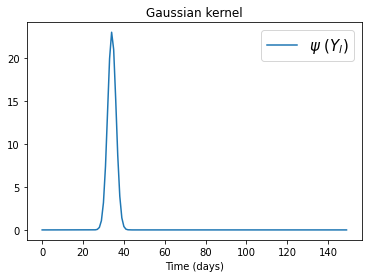

In [13]:
np.random.seed(0)

# generate a continuum light curve (x-band)
tc, fxc, errxc, rblr = photRM.LC_conti(6000)

# if you want to specify a time-lag (size of the BLR):
#tc, fxc, errxc, rblr = photRM.LC_conti(6000, rblr_flag=True, lag=42)

# use obtained continuum light curve to generate a continuum+line light curve (y-band)
x_band, y_band, line_response = photRM.LC_two_bands(tc, fxc, errxc, rblr)

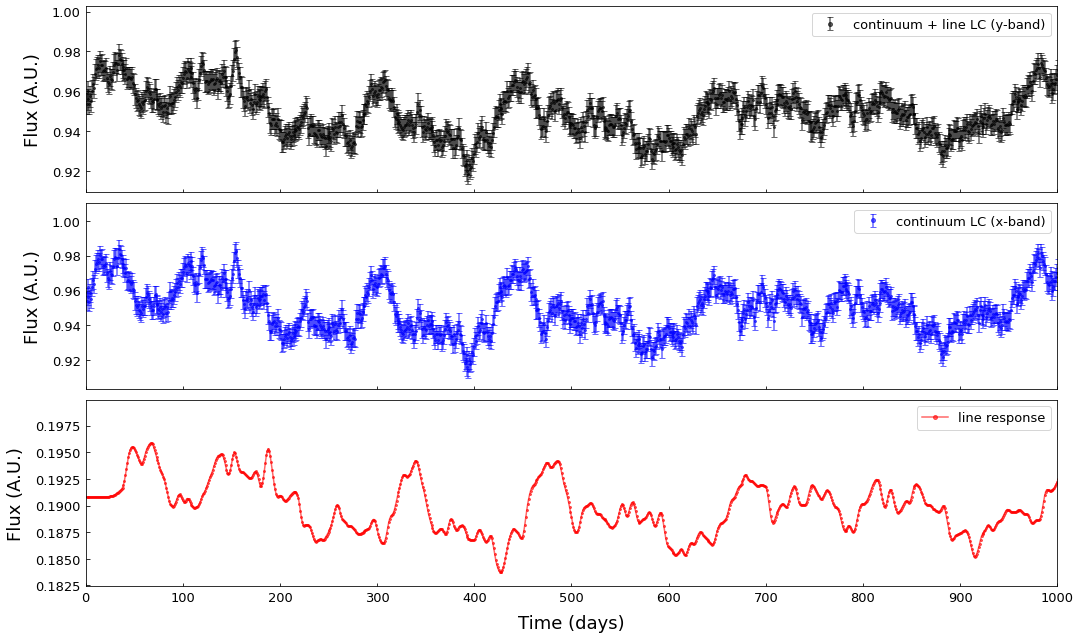

In [16]:
# Plot the light curves       

fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(15,9), tight_layout=True)

ax1.errorbar(y_band['t'], y_band['flux'], yerr= y_band['err'], fmt='ko', markersize=2,alpha=0.6,capsize=3, label='continuum + line LC (y-band)')
ax2.errorbar(x_band['t'], x_band['flux'], yerr= x_band['err'], fmt='bo', markersize=2,alpha=0.6,capsize=3, label='continuum LC (x-band)')
ax3.plot(line_response['t'], line_response['flux'],'ro-', markersize=2,alpha=0.6, label='line response')

loc = plticker.MultipleLocator(100) # this locator puts ticks at regular intervals

for ax in [ax1,ax2,ax3]:
    ax.legend(fontsize=13, markerscale=2)
    ax.set_ylabel('Flux (A.U.)',fontsize = 18,labelpad=10)
    ax.tick_params(direction='in', pad = 5, labelsize=13)
    ax.set_xlim(0,1000)
    ax.xaxis.set_major_locator(loc)


ax3.set_xlabel('Time (days)',fontsize = 18, labelpad=10)

plt.show()

In [17]:
# Save the data

dir_path = './fortran_dir/'

cut = 1000

np.savetxt(dir_path+'x_band_sim',np.c_[x_band.t[:cut], x_band.flux[:cut], x_band.err[:cut]], fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'y_band_sim',np.c_[y_band.t[:cut], y_band.flux[:cut], y_band.err[:cut]], fmt=['%.1f','%.7e','%.7e'])

# PhotoRM: simulated data

We now have our light curve data, let's recall the steps for performing photometric reverberation mapping:

- <font color='gray'>identify suitable filters: one needs to cover continuum emission ($X$-band) and the other needs to cover continuum + line emission ($Y$-band)</font>
- calculate auto-correlation function (ACF) of the continuum light curve
- calculate cross-correlation function (CCF) between continuum light curve and continuum + line light curve
- take their difference:
 </div>

$$
\begin{align}
CCF(\tau) = CCF_{YX}(\tau) - ACF_{X}(\tau)
\end{align}
$$

- find the peak in their difference, it will correspond to the time-lag ($\tau$)

ACFs and CCFs can be calculated using a Fortran program called Z-transformed Discrete Correlation Function (ZDCF).  
Download for free: https://www.weizmann.ac.il/particle/tal/research-activities/software

**ZDCF** is widely used algorithm to robustly estimate the cross-correlation function (CCF) of discrete, sparse astronomical time series (Alexander 1997). We provide a simple routine for calling the program directly from this notebook. The results obtained by running ZDCF are stored in the same folder as this notebook.

We will demonstrate the analysis process using **simulated light curves**. 

We also recommend to look at [Jankov et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022AN....34310090J/abstract), LSST Cadence Note ([Kovačević et al. 2021a](https://ui.adsabs.harvard.edu/abs/2021arXiv210512420K/abstract)) and [Kovačević et al. 2021b](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5012K/abstract) for interesting use cases of simulated light curves (e.g. as tools for evaluating Vera C. Rubin LSST survey strategies).

In [18]:
def ZDCF(path, current):
    """
    This function simulates the ZDCF input prompts and calls the actual program
    compiled in fortran using the command line. The compiled program needs to be
    in the same directory as this notebook. The results are also stored in the
    current directory.
    """
    os.chdir(path) # change to dir with Fortran program
    p1 = input("Auto-correlation or cross-correlation? (1/2)")
    p2 = input("Enter output files prefix:")
    p3 = input("Uniform sampling of light curve? (y/n)")
    p4 = input("Enter minimal number of points per bin (0 for default):")
    p5 = input("Omit zero-lag points? (y/n):")
    p6 = input("How many Monte Carlo runs for error estimation?")
    p7 = input("Enter name of 1st light curve file:")
    if p1 == '2':
        p8 = input("Enter name of 2nd light curve:")
        parameters = p1+'\n'+p2+'\n'+p3+'\n'+p4+'\n'+p5+'\n'+p6+'\n'+p7+'\n'+p8
    elif p1 == '1':
        parameters = p1+'\n'+p2+'\n'+p3+'\n'+p4+'\n'+p5+'\n'+p6+'\n'+p7
    !printf "{parameters}" | ./zdcf
    os.chdir(current[0]) # change back to current directory

It is very simple to run:

In [ ]:
path = "./fortran_dir/" # directory where Fortran program is located
current = !pwd          # current directory

ZDCF(path,current)

# For ACF enter: 1, output_filename, n, 0, y, 100, x_band_sim
# For CCF enter: 2, output_filename, n, 0, y, 100, x_band_sim, y_band_sim

# Note: It is VERY IMPORTANT to enter first the data with continuum only light 
# curve and then the data with continuum+line light curve! We want to measure how
# much the emission line lags behind the continuum, not other way around.

In [22]:
# Loading results from ZDCF

path = './fortran_dir/'

cols = ['tau', '-sig(tau)', '+sig(tau)', 'dcf', '-err(dcf)', '+err(dcf)', '#bin']
ccf = pd.read_csv(path + 'tutorial_sim_ccf.dcf', sep=" ", header=None, skipinitialspace=True)
acf = pd.read_csv(path + 'tutorial_sim_acf.dcf', sep=" ", header=None, skipinitialspace=True)

ccf.columns = cols
acf.columns = cols

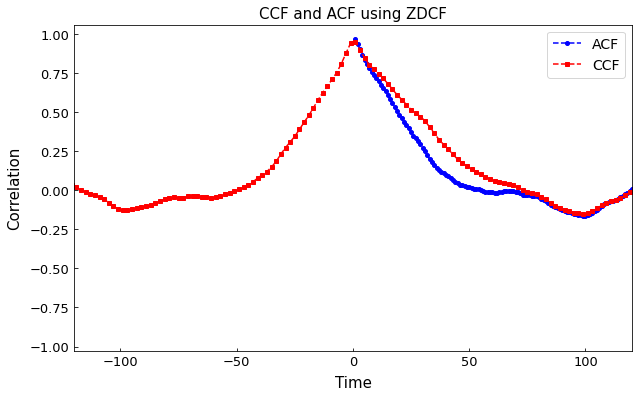

In [23]:
# Plot CCF and ACF

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf['tau'], acf['dcf'], 'o--b', label='ACF', markersize=4)
#ax.plot(-acf['tau'], acf['dcf'], 'o--b')
ax.plot(ccf['tau'], ccf['dcf'], 's--r', label='CCF', markersize=4)

ax.set_xlim(-120,120)
#ax.set_ylim(-0.25, 1.1)
ax.set_xlabel("Time", fontsize=15, labelpad=7)
ax.set_ylabel("Correlation", fontsize=15, labelpad=7)
ax.legend(fontsize=14)
ax.tick_params(direction='in', pad = 5, labelsize=13)
ax.set_title('CCF and ACF using ZDCF', fontsize=15)
#ax.grid(which='major', axis='x', linestyle='--')
plt.show()

We obtained $CCF(\mathrm{continuum \ \& \ line})$ and $ACF(\mathrm{continuum})$, we now need to calculate $CCF(\tau)$.

In [24]:
# since ZDCF does not provide the ACF on the negative tau axis, we need to add it:

acf_total = photRM.add_inverted_acf(acf)

print(acf_total.shape)
print(ccf.shape)

(1980, 7)
(992, 7)


In [25]:
# We still need to make CCF and ACF the same length so we could subtract them.
# We do this by interpolating one of those functions to the time grid of the other.

acf_interp = photRM.interp(ccf, acf_total) # first param is the function having the x-axis on which we want to interpolate the other function.
print(acf_interp.shape)
print(ccf.shape)

(992, 7)
(992, 7)


In [26]:
# Subtracting CCF and ACF
final_ccf = photRM.delta_ccf(acf_interp, ccf)

In [27]:
final_ccf.tail()

,tau,-sig(tau),+sig(tau),dcf,-err(dcf),+err(dcf),#bin
987,983.0,0,0,0.061802,0.237692,0.264717,17
988,985.0,0,0,0.091030,0.361755,0.381128,15
989,987.0,0,0,0.088995,0.425423,0.408181,13
990,989.0,0,0,0.047420,0.335416,0.289138,11
991,991.0,1,4,0.006563,0.331795,0.276730,10


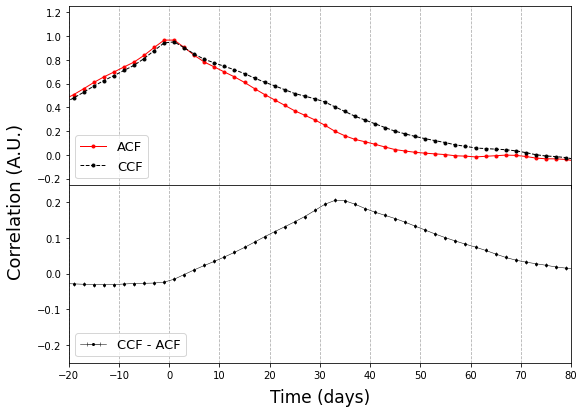

In [28]:
photRM.plot_ccf_acf(final_ccf, ccf, acf_interp, locator=10)

### PLIKE: Time-lag estimation by maximum likelihood

This program uses the output of ZDCF to estimate the likeliest peak in the function (in our case, we had to adapt the output because in photoRM time-lag is estimated from the CCF-ACF difference).

Download for free: https://www.weizmann.ac.il/particle/tal/research-activities/software

In [29]:
# Let's save the obtained ccf(tau) first, so it can be read into PLIKE

final_ccf.to_csv('fortran_dir/plike_input_sim.dcf', sep=" ", index=False, header=False)

In [30]:
# Function that calls PLIKE from this notebook

def PLIKE(path,current):
    os.chdir(path) # change to dir with Fortran program
    p1 = input("Enter dcf file name:")
    p2 = input("Enter lower bound on peak location:")
    p3 = input("Enter upper bound on peak location:")

    parameters = p1+'\n'+p2+'\n'+p3

    !printf "{parameters}" | ./plike
    os.chdir(current[0]) # change back to current directory

In [ ]:
# Now, let's run PLIKE

PLIKE(path, current)

# Input example for PLIKE: plike_input_sim.dcf, 0, 100

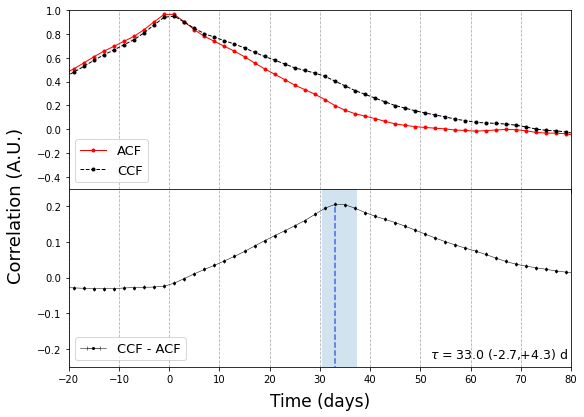

In [32]:
# PLIKE results:

tau = 33
err_low = -2.66
err_high = 4.35

photRM.plot_ccf_acf(final_ccf, ccf, acf_interp, locator=10, peak=True, tau=tau, err_low=err_low, err_high=err_high, x1=-20, x2=80, y1=-0.5, y2=1)

Time-lag estimated: **33 days** (real value = 34.11 days).

## PhotoRM: ZTF light curves

**Step 1:** For a given redshift range, find optimal filters for PhotoRM analysis

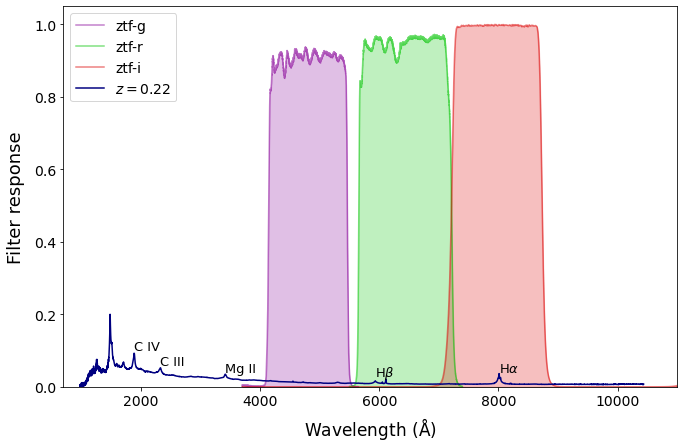

In [33]:
photRM.filters_viz(z=0.22, phot_sys='ZTF', save=False)

- **<font color='violet'> $g$-band covers continuum </font>**
- **<font color='#0AD304'>$r$-band covers Hb and continuum </font>**
- **<font color='indianred'> $i$-band covers Ha and continuum </font>**

We choose **g band** for pure continuum light curve (X-band) and **r band** for continuum + line light curve (Y-band).

**Note:** i-band light curves usually have much lower number of points compared to g and r bands, which is the reason for not considering it in this analysis.

In [34]:
# Select a subsample containing only objects with redshift between 0.2 - 0.25.

subsample = sources.loc[(sources['z'] < 0.25) & (sources['z'] >= 0.2)]

In [35]:
dr_path = './ZTF_data/ZTF_DR_data/' # where to save the DR light curve data in csv format

In [36]:
subsample.head()

,name,ra,dec,z,type
51,J133329.45+154550.0,203.372696,15.763903,0.24,AX
77,J095056.89+413347.3,147.737067,41.563156,0.24,AX
217,J020431.26+012204.9,31.130272,1.368052,0.21,AX
221,J161013.67+311756.4,242.556960,31.298994,0.24,A
287,J112933.14+402119.3,172.388083,40.355367,0.20,NR


**Step 2:** Query ZTF light curves based on the conditions posed by the filter choice from Step 1

- **condition 1:** redshift range 0.2 <= z < 0.25
- **condition 2:** light curve has more than 200 points in g and r bands

In [37]:
# Download light curves of the first object which satisfies above conditions

name = subsample.name
ra = subsample.ra
dec = subsample.dec
filters = ['g', 'r']
min_length = 200
j = 0

while True:
    flags = []
    lcs = []
    for f in filters:
        try:
            lc = get_ZTF_DR_lc(name.iloc[j],ra.values[j], dec.values[j], f, dr_path)
            lcs.append(lc)
            flags.append(True)
        except:   
            print("unsuccessful processing of {} in {} band".format(name.iloc[j], f)) #the light curve is probably not available in the ZTF DRs
            flags.append(False)
    print(62*'-')
    if ((sum(flags) == len(filters))):
        if len(filters)==2:
            if ((lcs[0].shape[0]>min_length) & (lcs[1].shape[0]>min_length)):
                print("Object {} has light curves in {} and {} bands.".format(name.iloc[j], filters[0], filters[1]))
                print("{}-band contains {} points.".format(filters[0], lcs[0].shape[0]))
                print("{}-band contains {} points.".format(filters[1], lcs[1].shape[0]))
                break
            else:
                j+=1
        elif len(filters)==3:
            if ((lcs[0].shape[0]>min_length) & (lcs[1].shape[0]>min_length) & (lcs[2].shape[0]>min_length)):
                print("Object {} has light curves in all three bands".format(name.iloc[j]))
                print("{}-band contains {} points.".format(filters[0], lcs[0].shape[0]))
                print("{}-band contains {} points.".format(filters[1], lcs[1].shape[0]))
                print("{}-band contains {} points.".format(filters[2], lcs[2].shape[0]))
                break
            else:
                j+=1
        else:
            print("Too many or too few filters!")
    else:
        j+=1

DR lc for object J133329.45+154550.0 in band g saved
DR lc for object J133329.45+154550.0 in band r saved
--------------------------------------------------------------
Object J133329.45+154550.0 has light curves in g and r bands.
g-band contains 331 points.
r-band contains 421 points.


In [38]:
# Read the downloaded light curves for one object

obj_name = 'J133329.45+154550.0'
print("Object name: SDSS {}".format(obj_name))

lc_g = pd.read_csv(dr_path+obj_name+'_DR_'+'g'+'band.csv')
lc_r = pd.read_csv(dr_path+obj_name+'_DR_'+'r'+'band.csv')
#lc_i = pd.read_csv(dr_path+obj_name+'_DR_'+'i'+'band.csv')

# Show an example of the light curve table in one band
print("Band: g")
display(lc_g.tail())

Object name: SDSS J133329.45+154550.0
Band: g


,oid,mjd,mag,magerr,catflags,filtercode,ra,dec
326,578102400001769,59402.207072,18.004089,0.028653,0,zg,203.372716,15.763935
327,578102400001769,59406.207639,18.038853,0.029223,0,zg,203.372742,15.763951
328,578102400001769,59409.223472,18.077980,0.029885,0,zg,203.372777,15.763923
329,578102400001769,59414.242535,18.067314,0.029702,0,zg,203.372725,15.763928
330,578102400001769,59417.184329,18.202179,0.032147,32768,zg,203.372733,15.763993


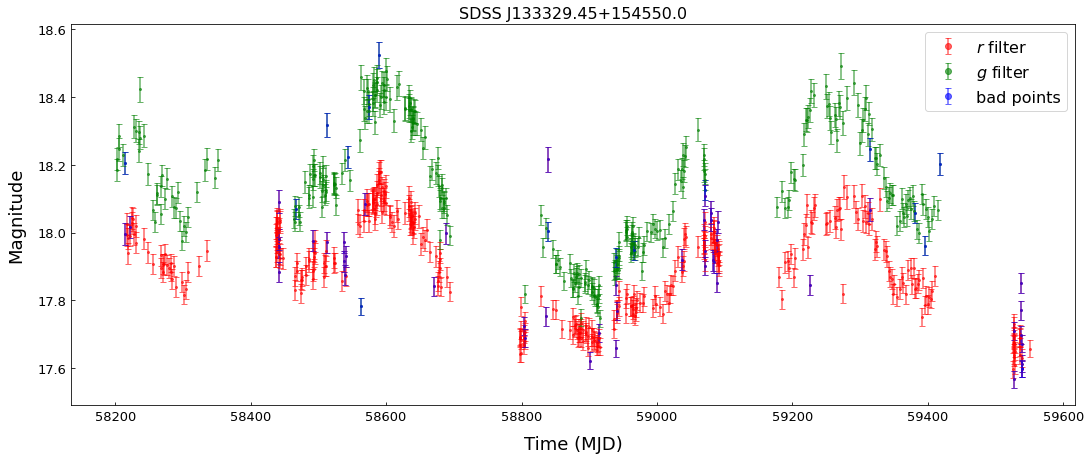

In [39]:
# Plot the light curves       

fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot()

ax.errorbar(lc_r.mjd, lc_r.mag, yerr= lc_r.magerr, fmt='ro', markersize=2,alpha=0.6,capsize=3, label=r'$r$ filter')
ax.errorbar(lc_g.mjd, lc_g.mag, yerr= lc_g.magerr, fmt='go', markersize=2,alpha=0.6,capsize=3, label=r'$g$ filter')
#ax.errorbar(lc_i.mjd, lc_i.mag, yerr= lc_i.magerr, fmt='ko', markersize=2,alpha=0.6,capsize=3, label=r'$i$  filter')

ax.errorbar(lc_r.loc[lc_r['catflags']!=0].mjd, lc_r[lc_r['catflags']!=0].mag, yerr= lc_r[lc_r['catflags']!=0].magerr, fmt='bo', markersize=2,alpha=0.6,capsize=3)
ax.errorbar(lc_g.loc[lc_g['catflags']!=0].mjd, lc_g[lc_g['catflags']!=0].mag, yerr= lc_g[lc_g['catflags']!=0].magerr, fmt='bo', markersize=2,alpha=0.6,capsize=3, label=r'bad points')
#ax.errorbar(lc_i.loc[lc_i['catflags']!=0].mjd, lc_i[lc_i['catflags']!=0].mag, yerr= lc_i[lc_i['catflags']!=0].magerr, fmt='ro', markersize=2,alpha=0.6,capsize=3, label=r'bad points')

ax.set_xlabel('Time (MJD)',fontsize = 18, labelpad=12)
ax.set_ylabel('Magnitude',fontsize = 18,labelpad=12)
ax.tick_params(direction='in', pad = 5, labelsize=13)
ax.legend(fontsize=16, markerscale=3)
ax.set_title("SDSS {}".format(obj_name), size=16)
plt.show()

**Step 3:** Prepare light curves for ZDCF

In [40]:
# Pre-processing

lc_g.sort_values(by='mjd', inplace=True)
lc_r.sort_values(by='mjd', inplace=True)

lc_g = lc_g.loc[lc_g['catflags']==0]
lc_r = lc_r.loc[lc_r['catflags']==0]

lc_g['mjd'] = lc_g['mjd']-lc_g['mjd'].min()
lc_r['mjd'] = lc_r['mjd']-lc_r['mjd'].min()

print("g-band covers continuum")
print("r-band covers Hb and continuum")

g-band covers continuum
r-band covers Hb and continuum


In [41]:
# Save the data

dir_path = './fortran_dir/'

x_band = lc_g[['mjd', 'mag', 'magerr']]
y_band = lc_r[['mjd', 'mag', 'magerr']]

x_band.columns = ['t','flux','err']
y_band.columns = ['t','flux','err']

np.savetxt(dir_path+'x_band_ztf',np.c_[x_band.t[:], x_band.flux[:], x_band.err[:]], fmt=['%.2f','%.7e','%.7e'])
np.savetxt(dir_path+'y_band_ztf',np.c_[y_band.t[:], y_band.flux[:], y_band.err[:]], fmt=['%.2f','%.7e','%.7e'])

**Step 4:** Calculate ACF and CCF using ZDCF

In [ ]:
path = "./fortran_dir/"
current = !pwd

ZDCF(path, current)

# For ACF enter: 1, output_filename, n, 0, y, 100, x_band_ztf
# For CCF enter: 2, output_filename, n, 0, y, 100, x_band_ztf, y_band_ztf

In [44]:
# Loading results from ZDCF

cols = ['tau', '-sig(tau)', '+sig(tau)', 'dcf', '-err(dcf)', '+err(dcf)', '#bin']
ccf = pd.read_csv(path + 'tutorial_ztf_ccf.dcf', sep=" ", header=None, skipinitialspace=True)
acf = pd.read_csv(path + 'tutorial_ztf_acf.dcf', sep=" ", header=None, skipinitialspace=True)

ccf.columns = cols
acf.columns = cols

**Step 5:** Interpolate CCF or ACF so they contain same number of points 

In [45]:
acf_total = photRM.add_inverted_acf(acf)
print(acf_total.shape)
print(ccf.shape)

acf_interp = photRM.interp(ccf,acf_total) # first param is the function having the x-axis on which we want to interpolate the other function.
print(acf_interp.shape)
print(ccf.shape)

(282, 7)
(142, 7)
(142, 7)
(142, 7)


**Step 6:** Subtract CCF and ACF

In [46]:
final_ccf = photRM.delta_ccf(acf_interp, ccf)

**Step 7:** Plot the results

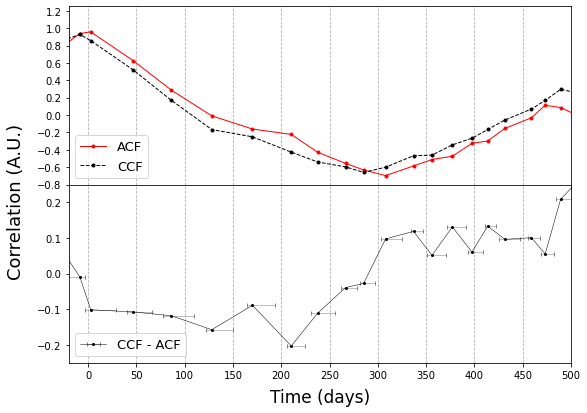

In [47]:
photRM.plot_ccf_acf(final_ccf, ccf, acf_interp, locator=50, x1=-20, x2=500, y1=-0.8, y2=1.25)

**Step 8:** Estimate the likeliest peak (time-lag estimation) using PLIKE

In [48]:
# save CCF-ACF for PLIKE
final_ccf.to_csv('fortran_dir/plike_input_ztf.dcf', sep=" ", index=False, header=False)

In [ ]:
PLIKE(path, current)

# Input example for PLIKE: plike_input_ztf.dcf, 200, 400

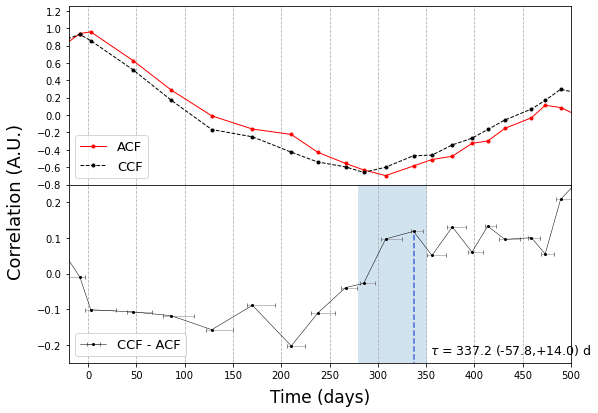

In [50]:
# PLIKE results:

tau = 337.2
err_low = -57.8
err_high = 14

photRM.plot_ccf_acf(final_ccf, ccf, acf_interp, locator=50, peak=True, tau=tau, err_low=err_low, err_high=err_high, x1=-20, x2=500, y1=-0.8, y2=1.25)

Time-lag estimated: **337.2 days**

# Python resources

- [Official Python 3 Documentation](https://docs.python.org/3/library/index.html) - "official"/technical explanation of what a particular function/operator
does, examples of correct syntax, what the various libraries are, etc.
- [Python Cheat Sheet](https://perso.limsi.fr/pointal/_media/python:cours:mementopython3-english.pdf) - self-explanatory
- [Think Python](https://greenteapress.com/wp/think-python-2e/) by Allen Downey - a good general overview of the Python language. Includes exercises.
- [Automate the Boring Stuff with Python](https://automatetheboringstuff.com/) by Al Sweigart - learn how to use Python to write programs that do in minutes what would take you hours to do by hand - no prior programming experience required.
- [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) by Jake VanderPlas - comprehensive introduction to scientific computing and data science with Python, written by astronomer.  
- [PEP 8](https://peps.python.org/pep-0008/) - Style Guide for Python Code - learn what is good and bad style in Python
- [Python Tutor](https://pythontutor.com/) - an excellent way to actually visualize how the interpreter reads and executes your code
- [DiffChecker](https://www.diffchecker.com/) - compares two sets of text and shows you which lines are different
- [Stack Overflow](https://stackoverflow.com/questions/tagged/python) - a large Q&A forum for programming concepts (not just Python).

# References

Alexander, T. 1997, in: Astronomical Time Series, eds. D. Maoz, A. Sternberg, & E. M. Leibowitz, Vol. 218, Springer, [Is AGN Variability Correlated with Other AGN Properties? ZDCF Analysis of Small Samples of Sparse Light Curves](https://ui.adsabs.harvard.edu/abs/1997ASSL..218..163A/abstract)  
Chelouche, D., & Daniel, E. [2012, ApJ, 747, 62.](https://ui.adsabs.harvard.edu/abs/2012ApJ...747...62C/abstract)  
Jankov, I., Kovačević A. B., Ilić, D., et al. [2022, Astronomische Nachrichten, 343, e210090](https://ui.adsabs.harvard.edu/abs/2022AN....34310090J/abstract)  
Kelly, B. C., Bechtold, J., & Siemiginowska, A. [2009, ApJ, 698, 895.](https://ui.adsabs.harvard.edu/abs/2009ApJ...698..895K/abstract)  
Kovačević, A., Ilić, D., Jankov, I. [2021a, arXiv:2105.12420](https://ui.adsabs.harvard.edu/abs/2021arXiv210512420K/abstract)  
Kovačević, A. B., Ilić, D., Popović, L. Č., et al. [2021b, MNRAS, 505, 5012](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5012K/abstract)   
Sánchez-Sáez, P., Lira, H., Martí, L., et al. [2021, AJ, 162, 206](https://ui.adsabs.harvard.edu/abs/2021AJ....162..206S/abstract)
